<a href="https://www.kaggle.com/wxmkevin/tabular-playground-jan-2022-eda?scriptVersionId=87340623" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

path = '/kaggle/input/tabular-playground-series-jan-2022/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
train_df = pd.read_csv(path + 'train.csv', index_col=0, parse_dates=['date']).set_index('date', drop=False)
test_df = pd.read_csv(path + 'test.csv', index_col=0, parse_dates=['date']).set_index('date', drop=False)

In [3]:
train_df.head()

date  country       store         product  num_sold
date                                                                
2015-01-01 2015-01-01  Finland  KaggleMart      Kaggle Mug       329
2015-01-01 2015-01-01  Finland  KaggleMart      Kaggle Hat       520
2015-01-01 2015-01-01  Finland  KaggleMart  Kaggle Sticker       146
2015-01-01 2015-01-01  Finland  KaggleRama      Kaggle Mug       572
2015-01-01 2015-01-01  Finland  KaggleRama      Kaggle Hat       911

In [4]:
train_df['year'] = train_df.date.dt.year
# train_df['num_sold'] = np.log(train_df.num_sold)
for col in ['country', 'store', 'product']:
    train_df[col] = train_df[col].str.replace(' ', '_')

# Is there a trend?

In [5]:
yearly = train_df.groupby(['year', 'store', 'product', 'country']).sum()[['num_sold']].reset_index()

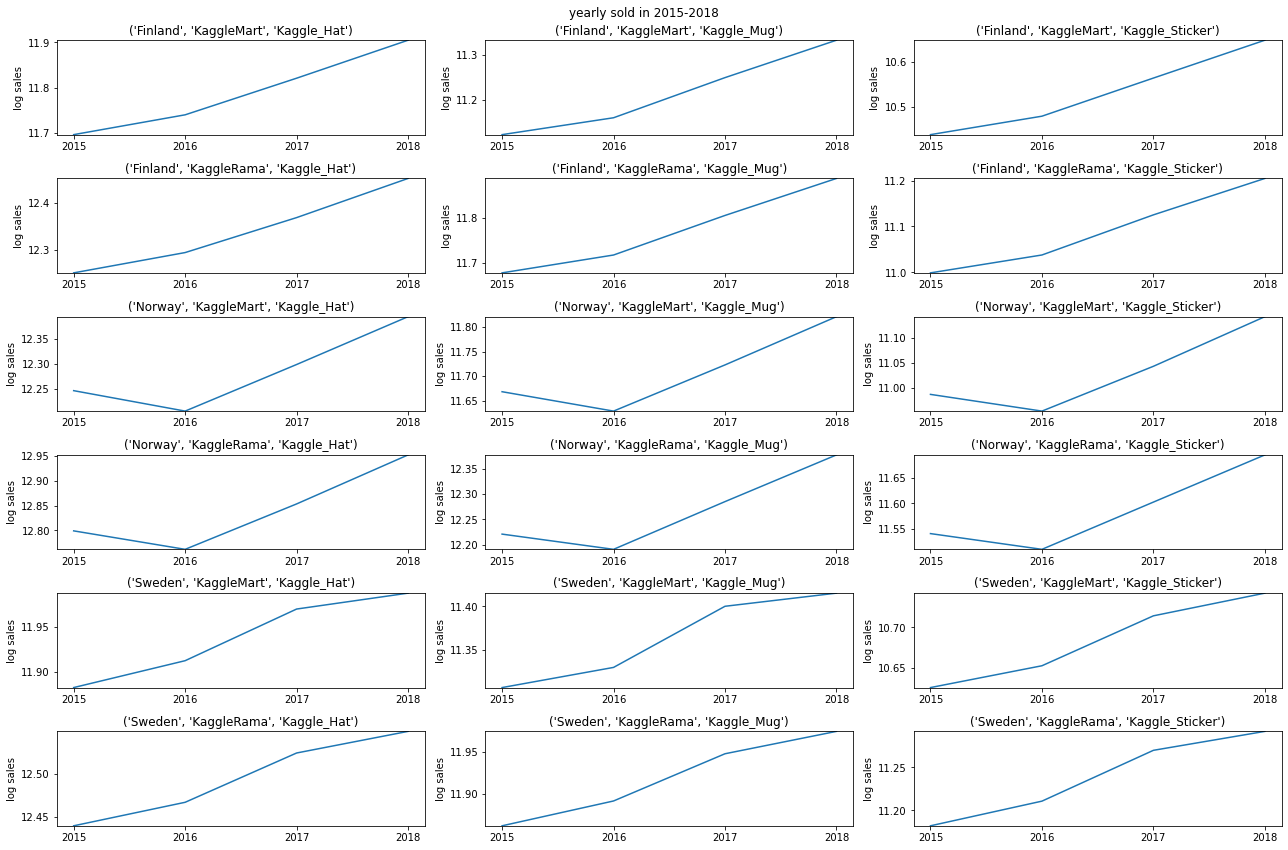

In [6]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.set_title(combi)
    ax.set_ylim(df.num_sold.min(), df.num_sold.max())
    ax.set_ylabel('log sales')
    ax.set_xticks(range(2015, 2019))
    ax.plot(range(2015, 2019), df.num_sold)
plt.suptitle('yearly sold in 2015-2018')
plt.tight_layout()
plt.show()

In [7]:
result = pd.DataFrame(columns=['coef', 'p_value'])
dp = DeterministicProcess(index=range(4), order=1, constant=True)
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    X = dp.in_sample()
    y = np.array(df.num_sold)
    res = sm.OLS(y, X).fit()
    ans = [res.params[1], res.pvalues[1]]
    result.loc[str(combi)] = ans
result

coef   p_value
('Finland', 'KaggleMart', 'Kaggle_Hat')      0.070874  0.009106
('Finland', 'KaggleMart', 'Kaggle_Mug')      0.071180  0.013050
('Finland', 'KaggleMart', 'Kaggle_Sticker')  0.071622  0.010869
('Finland', 'KaggleRama', 'Kaggle_Hat')      0.067709  0.009189
('Finland', 'KaggleRama', 'Kaggle_Mug')      0.072522  0.011435
('Finland', 'KaggleRama', 'Kaggle_Sticker')  0.070634  0.011247
('Norway', 'KaggleMart', 'Kaggle_Hat')       0.054322  0.149740
('Norway', 'KaggleMart', 'Kaggle_Mug')       0.055089  0.144226
('Norway', 'KaggleMart', 'Kaggle_Sticker')   0.055199  0.131733
('Norway', 'KaggleRama', 'Kaggle_Hat')       0.054880  0.140451
('Norway', 'KaggleRama', 'Kaggle_Mug')       0.056166  0.118079
('Norway', 'KaggleRama', 'Kaggle_Sticker')   0.055848  0.121640
('Sweden', 'KaggleMart', 'Kaggle_Hat')       0.037464  0.018479
('Sweden', 'KaggleMart', 'Kaggle_Mug')       0.039710  0.032724
('Sweden', 'KaggleMart', 'Kaggle_Sticker')   0.040912  0.013536
('Sweden', 'KaggleRama', 'Kaggle_Hat')       0.038546  0.012750
('Sweden', 'KaggleRama', 'Kaggle_Mug')       0.038861  0.010188
('Sweden', 'KaggleRama', 'Kaggle_Sticker')   0.038786  0.015455

From the above p value, we see that Finland and Sweden trends are significant while Norway's is not. The Kaggle discussion says that it has a correlation with GDP so we would like to see if trends still exist with GDP regression.

In [8]:
gdp_df = pd.DataFrame([[234.440, 385.802, 505.104], [240.608, 368.827, 515.655], [255.017, 398.394, 541.019], [275.580, 437.000, 555.455], [268.782, 405.510, 533.880]], 
                   index=[2015, 2016, 2017, 2018, 2019], columns=['Finland', 'Norway', 'Sweden'])

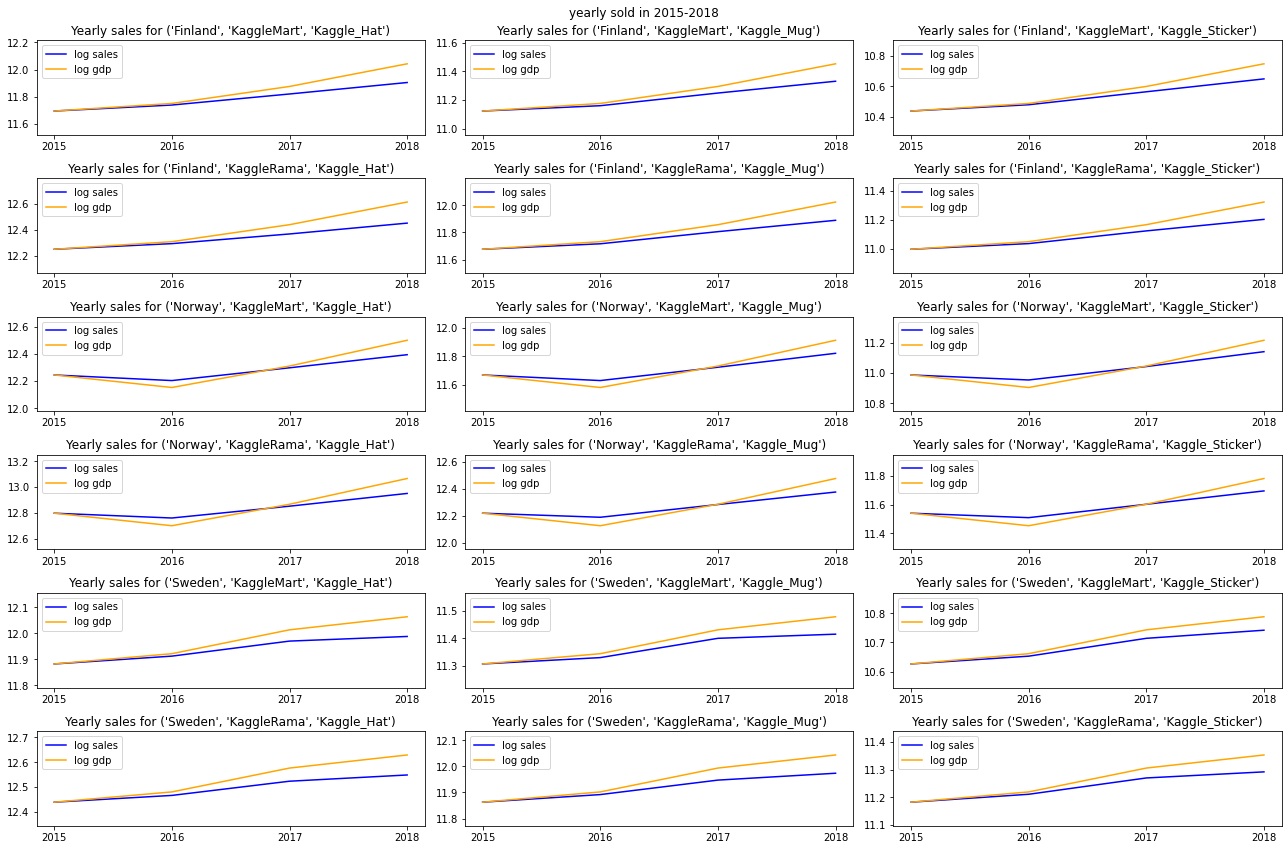

In [9]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
#     ax.set_ylim(df.num_sold.min(), df.num_sold.max())
    ax.set_xticks(range(2015, 2019))
    ax.plot(range(2015, 2019), df.num_sold, color='blue', label='log sales')
    ax.plot(range(2015, 2019), gdp / gdp.iloc[0] * df.num_sold.iloc[0], color='orange', label='log gdp')
    ax.legend()
    ax.set_title(f"Yearly sales for {combi}")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.suptitle('yearly sold in 2015-2018')
plt.tight_layout()
plt.show()

In [10]:
result = pd.DataFrame(columns=['coef', 'p_value'])
dp = DeterministicProcess(index=range(4), order=1, constant=True)
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
#     X = dp.in_sample()
    y = np.array(df.num_sold)
    res = sm.OLS(y, sm.add_constant(gdp)).fit()
    ans = [res.params[1], res.pvalues[1]]
    result.loc[str(combi)] = ans
result

coef   p_value
('Finland', 'KaggleMart', 'Kaggle_Hat')      1.282890  0.003732
('Finland', 'KaggleMart', 'Kaggle_Mug')      1.293355  0.003904
('Finland', 'KaggleMart', 'Kaggle_Sticker')  1.298993  0.003540
('Finland', 'KaggleRama', 'Kaggle_Hat')      1.226551  0.003044
('Finland', 'KaggleRama', 'Kaggle_Mug')      1.315079  0.004292
('Finland', 'KaggleRama', 'Kaggle_Sticker')  1.279799  0.004908
('Norway', 'KaggleMart', 'Kaggle_Hat')       1.145036  0.003321
('Norway', 'KaggleMart', 'Kaggle_Mug')       1.153044  0.003920
('Norway', 'KaggleMart', 'Kaggle_Sticker')   1.136622  0.005755
('Norway', 'KaggleRama', 'Kaggle_Hat')       1.143234  0.004245
('Norway', 'KaggleRama', 'Kaggle_Mug')       1.133370  0.010340
('Norway', 'KaggleRama', 'Kaggle_Sticker')   1.132959  0.009080
('Sweden', 'KaggleMart', 'Kaggle_Hat')       1.125519  0.006522
('Sweden', 'KaggleMart', 'Kaggle_Mug')       1.207563  0.009001
('Sweden', 'KaggleMart', 'Kaggle_Sticker')   1.230151  0.000674
('Sweden', 'KaggleRama', 'Kaggle_Hat')       1.157329  0.001339
('Sweden', 'KaggleRama', 'Kaggle_Mug')       1.163599  0.001462
('Sweden', 'KaggleRama', 'Kaggle_Sticker')   1.165606  0.003160

From the p value, we can see GDP plays an important role in sales. We then take a look at the residuals and see if residuals still have a trend.

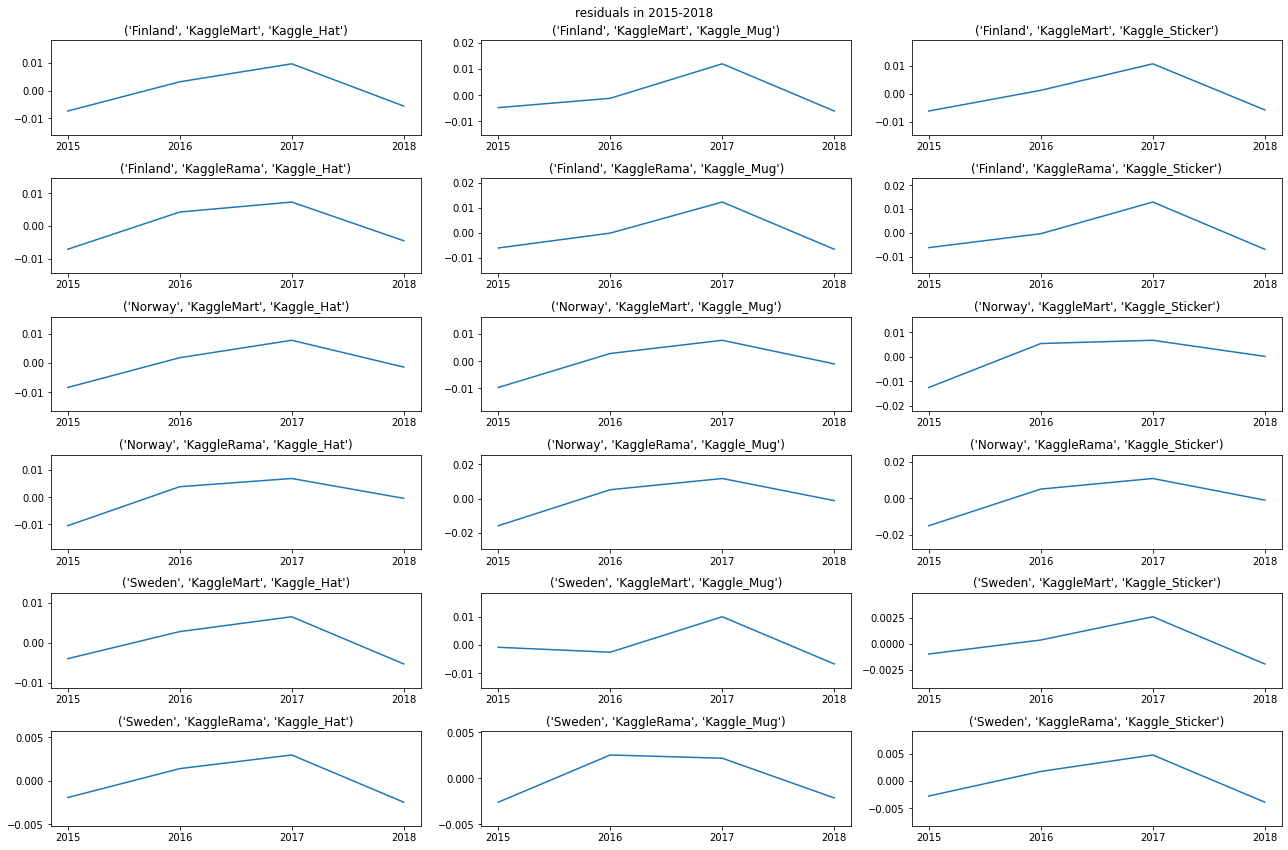

In [11]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
#     X = dp.in_sample()
    y = np.array(df.num_sold)
    res = sm.OLS(y, sm.add_constant(gdp)).fit()
    residual = y - res.predict(sm.add_constant(gdp))
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.set_xticks(range(2015, 2019))
    ax.plot(range(2015, 2019), residual)
    ax.set_title(combi)
plt.suptitle('residuals in 2015-2018')
plt.tight_layout()
plt.show()

In [12]:
result = pd.DataFrame(columns=['coef', 'p_value'])
dp = DeterministicProcess(index=range(4), order=1, constant=True)
for i, (combi, df) in enumerate(yearly.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
    X = dp.in_sample()
    y = np.array(df.num_sold)
    res = sm.OLS(y, sm.add_constant(gdp)).fit()
    residual = y - res.predict(sm.add_constant(gdp))
    res = sm.OLS(np.array(residual), X).fit()
    ans = [res.params[1], res.pvalues[1]]
    result.loc[str(combi)] = ans
result

coef   p_value
('Finland', 'KaggleMart', 'Kaggle_Hat')      0.001188  0.807566
('Finland', 'KaggleMart', 'Kaggle_Mug')      0.000926  0.854616
('Finland', 'KaggleMart', 'Kaggle_Sticker')  0.001061  0.825640
('Finland', 'KaggleRama', 'Kaggle_Hat')      0.001083  0.796653
('Finland', 'KaggleRama', 'Kaggle_Mug')      0.001088  0.839781
('Finland', 'KaggleRama', 'Kaggle_Sticker')  0.001116  0.842159
('Norway', 'KaggleMart', 'Kaggle_Hat')       0.002687  0.483422
('Norway', 'KaggleMart', 'Kaggle_Mug')       0.003094  0.456613
('Norway', 'KaggleMart', 'Kaggle_Sticker')   0.003944  0.420844
('Norway', 'KaggleRama', 'Kaggle_Hat')       0.003327  0.433931
('Norway', 'KaggleRama', 'Kaggle_Mug')       0.005058  0.446307
('Norway', 'KaggleRama', 'Kaggle_Sticker')   0.004758  0.443415
('Sweden', 'KaggleMart', 'Kaggle_Hat')      -0.000026  0.994090
('Sweden', 'KaggleMart', 'Kaggle_Mug')      -0.000512  0.906871
('Sweden', 'KaggleMart', 'Kaggle_Sticker')  -0.000063  0.958801
('Sweden', 'KaggleRama', 'Kaggle_Hat')      -0.000003  0.998667
('Sweden', 'KaggleRama', 'Kaggle_Mug')       0.000103  0.951623
('Sweden', 'KaggleRama', 'Kaggle_Sticker')  -0.000038  0.987743

Now we can see the huge p value shows there is no trend in any combination after partialling out GDP.

# Different Sales between Countries

We would like to see if there is any difference of sales principles between countries. 

## Finland vs Norway

In [13]:
df1 = train_df.query('country == "Finland" | country == "Norway"')

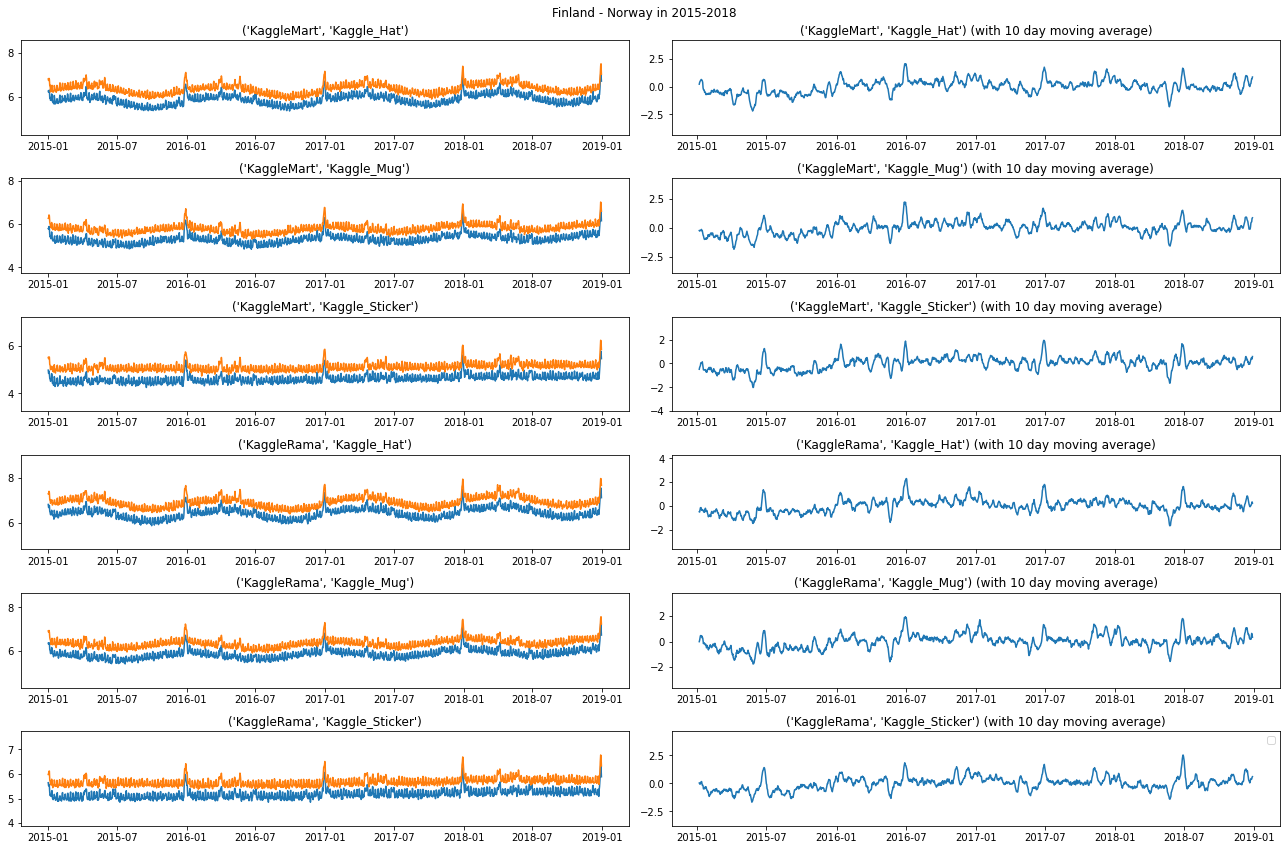

In [14]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 2, i * 2 + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), df[df.country == 'Finland'].num_sold, label='Finland')
    ax.plot(df.index.unique(), df[df.country == 'Norway'].num_sold, label='Norway')
    ax.set_title(combi)
    ax2 = plt.subplot(6, 2, i * 2 + 2, ymargin=0.5)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax2.plot(df.index.unique(), differ)
    ax2.set_title(f"{combi} (with 10 day moving average)")
plt.suptitle('Finland - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

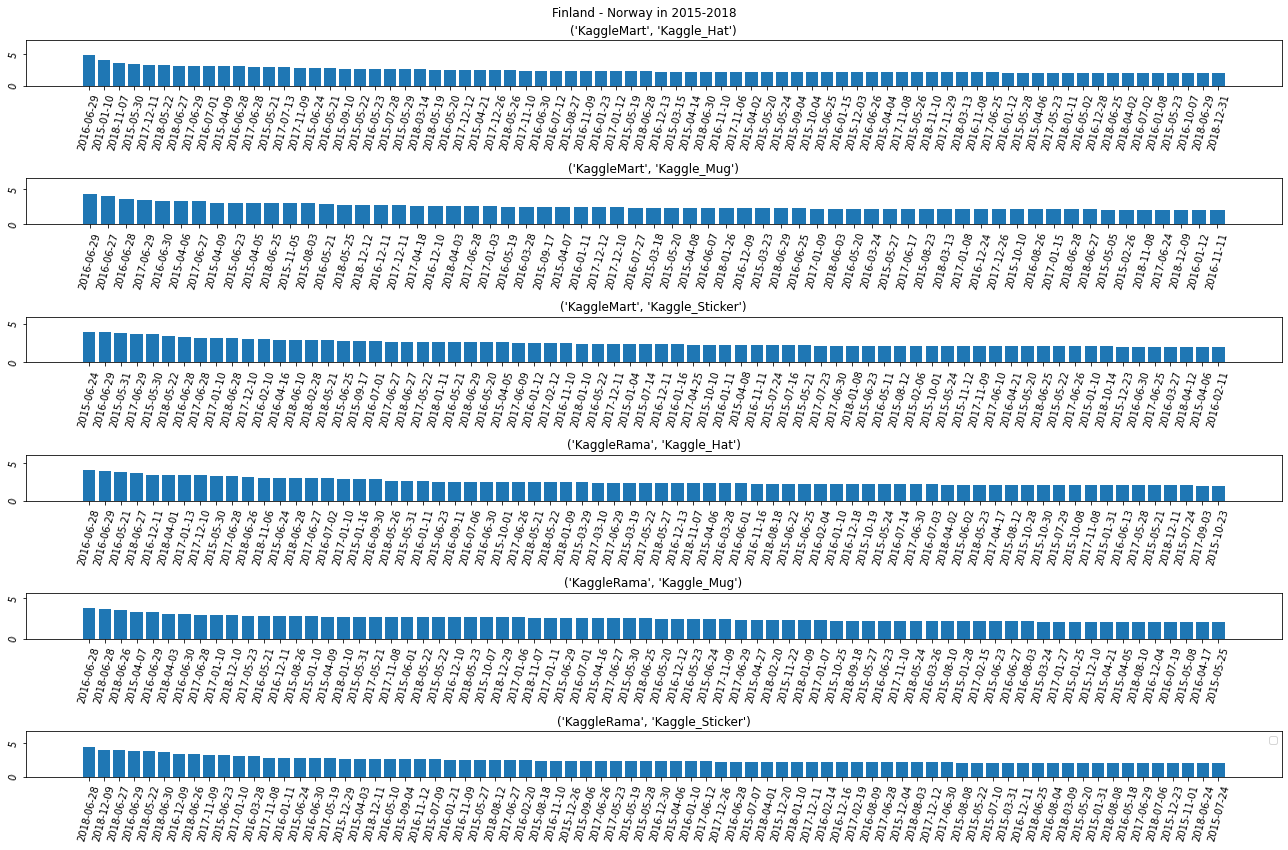

In [15]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax2 = plt.subplot(6, 1, i + 1, ymargin=0.5)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ).sort_values(ascending=False)
    differ = differ[differ > 2]
    ax2.bar(differ.index.astype(str), differ)
    ax2.set_title(f"{combi}")
    ax2.tick_params(rotation=75)
plt.suptitle('Finland - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

To see them more clearly, we draw a plot about the outliers

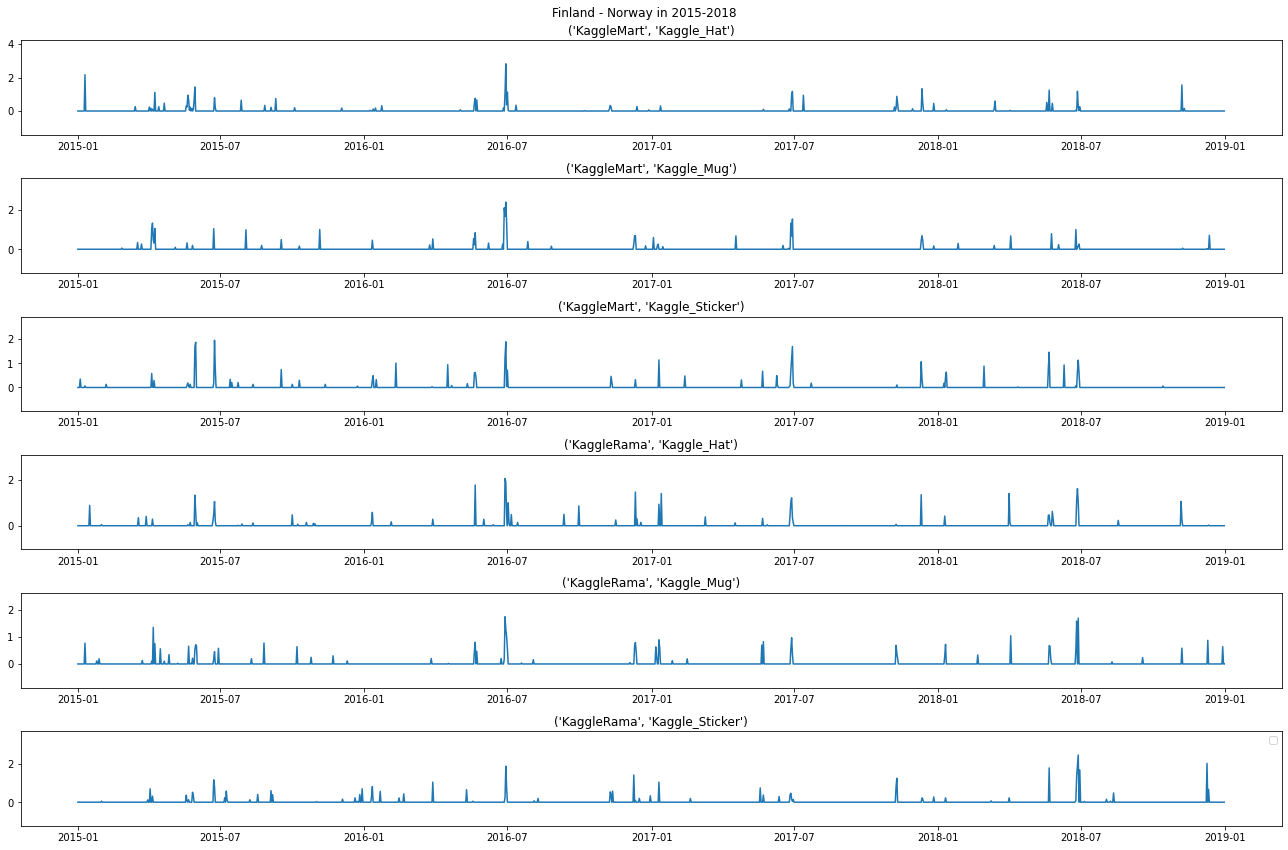

In [16]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 1, i + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 2
    differ[differ < 0] = 0
#     differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), differ)
    ax.set_title(f"{combi}")
plt.suptitle('Finland - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

Sum them up and we get

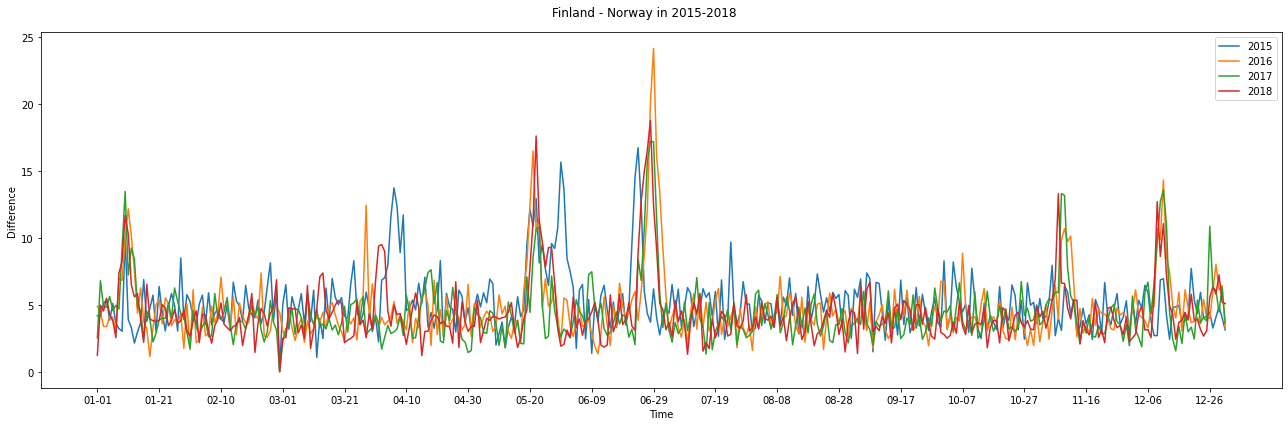

In [17]:
plt.figure(figsize=(18, 6))
res = None
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
#     differ -= 2
    differ[differ < 0] = 0
    if res is None:
        res = differ
    else:
        res += differ
res[res < 0] = 0
dates = sorted(res.index.strftime('%m-%d').unique())
for year in range(2015, 2019):
    data = res[res.index.year == year]
    data.index = data.index.strftime('%m-%d')
    plt.plot(dates, data.reindex(dates).fillna(0), label=year)
plt.xticks(dates[::20])
plt.ylabel('Difference')
plt.xlabel('Time')
plt.suptitle('Finland - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

In conclusion, the difference between Finland and Norway falls on the date of the followings:

1. Around Jan 10.

2. End of May.

3. End of June.

4. Beginning of November.

5. Beginning of December.

## Sweden vs Norway

In [18]:
df1 = train_df.query('country == "Sweden" | country == "Norway"')

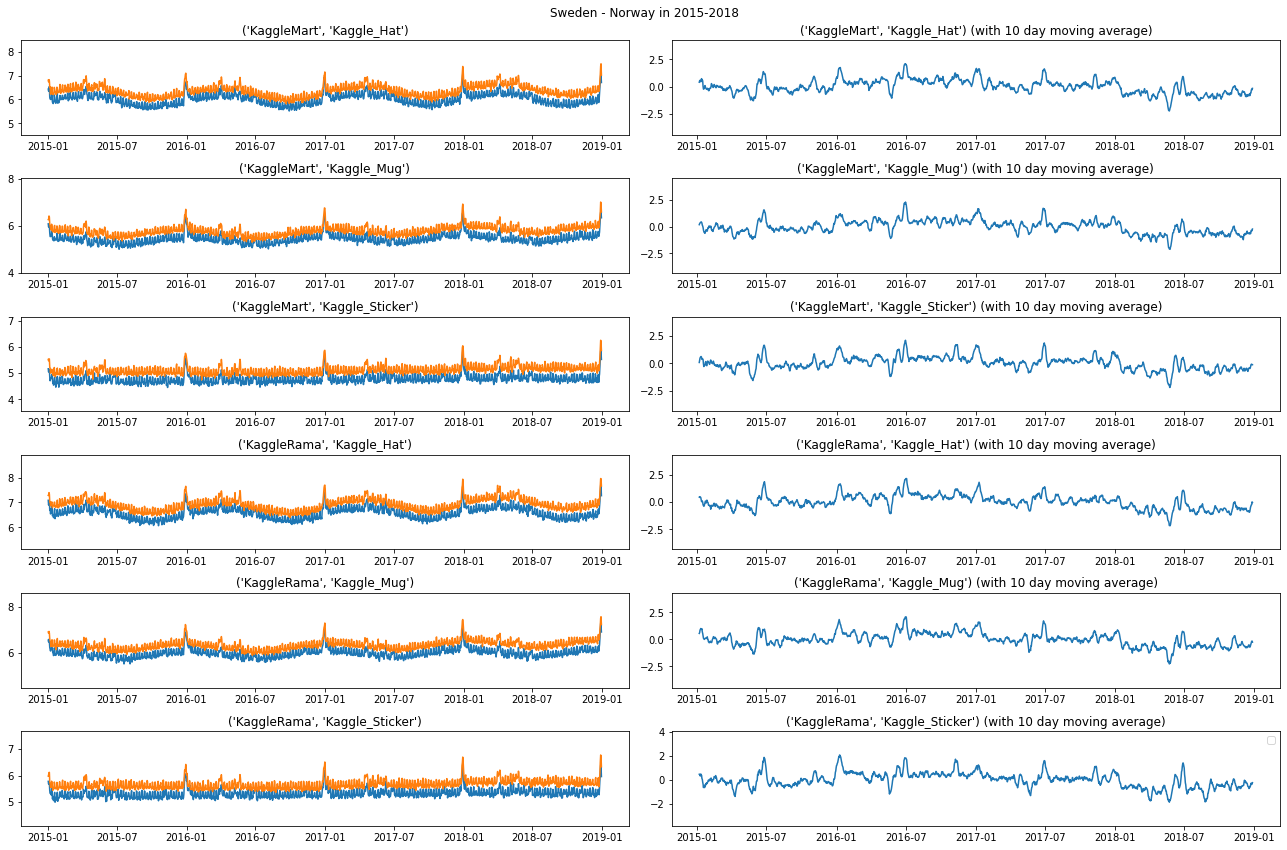

In [19]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 2, i * 2 + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), df[df.country == 'Sweden'].num_sold, label='Sweden')
    ax.plot(df.index.unique(), df[df.country == 'Norway'].num_sold, label='Norway')
    ax.set_title(combi)
    ax2 = plt.subplot(6, 2, i * 2 + 2, ymargin=0.5)
    differ = df[df.country == 'Sweden'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax2.plot(df.index.unique(), differ)
    ax2.set_title(f"{combi} (with 10 day moving average)")
plt.suptitle('Sweden - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

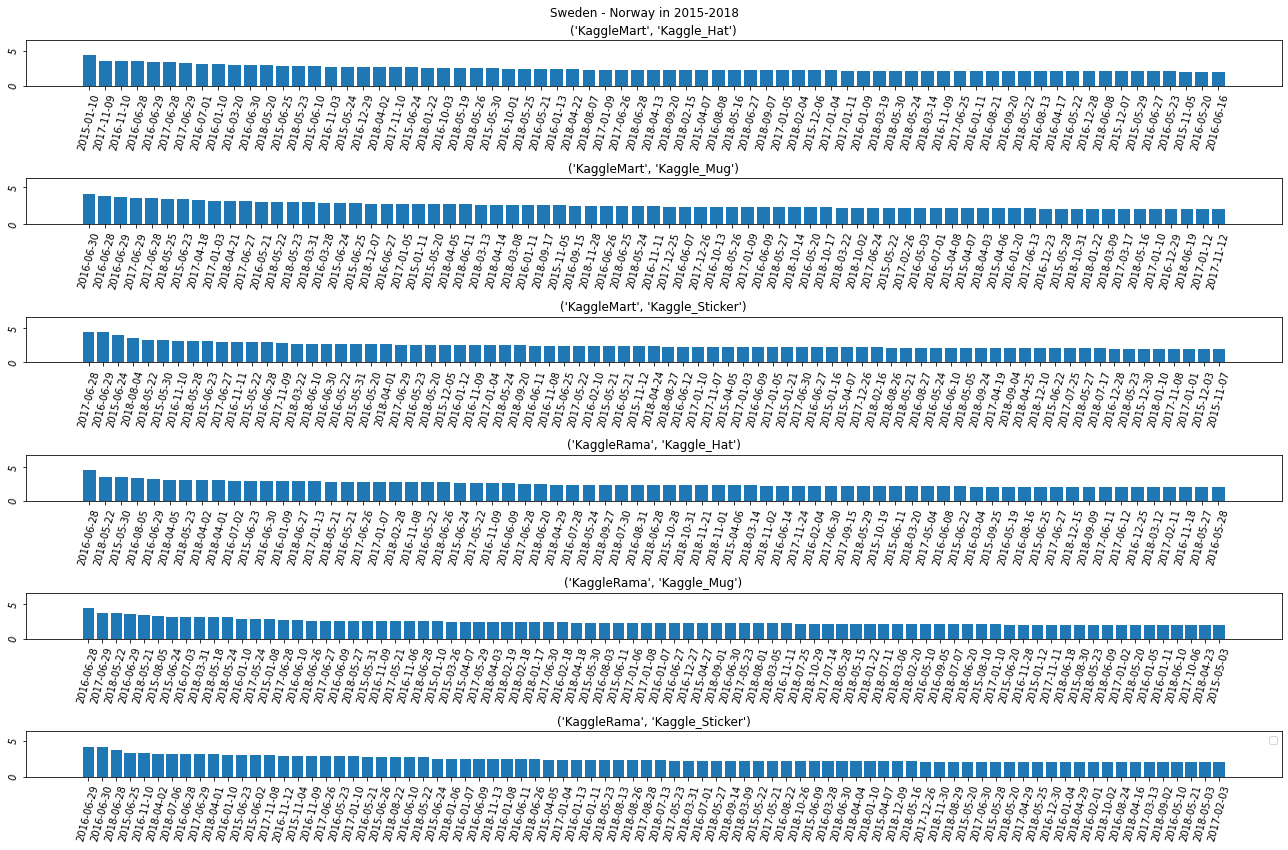

In [20]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax2 = plt.subplot(6, 1, i + 1, ymargin=0.5)
    differ = df[df.country == 'Sweden'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ).sort_values(ascending=False)
    differ = differ[differ > 2]
    ax2.bar(differ.index.astype(str), differ)
    ax2.set_title(f"{combi}")
    ax2.tick_params(rotation=75)
plt.suptitle('Sweden - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

To see them more clearly, we draw a plot about the outliers

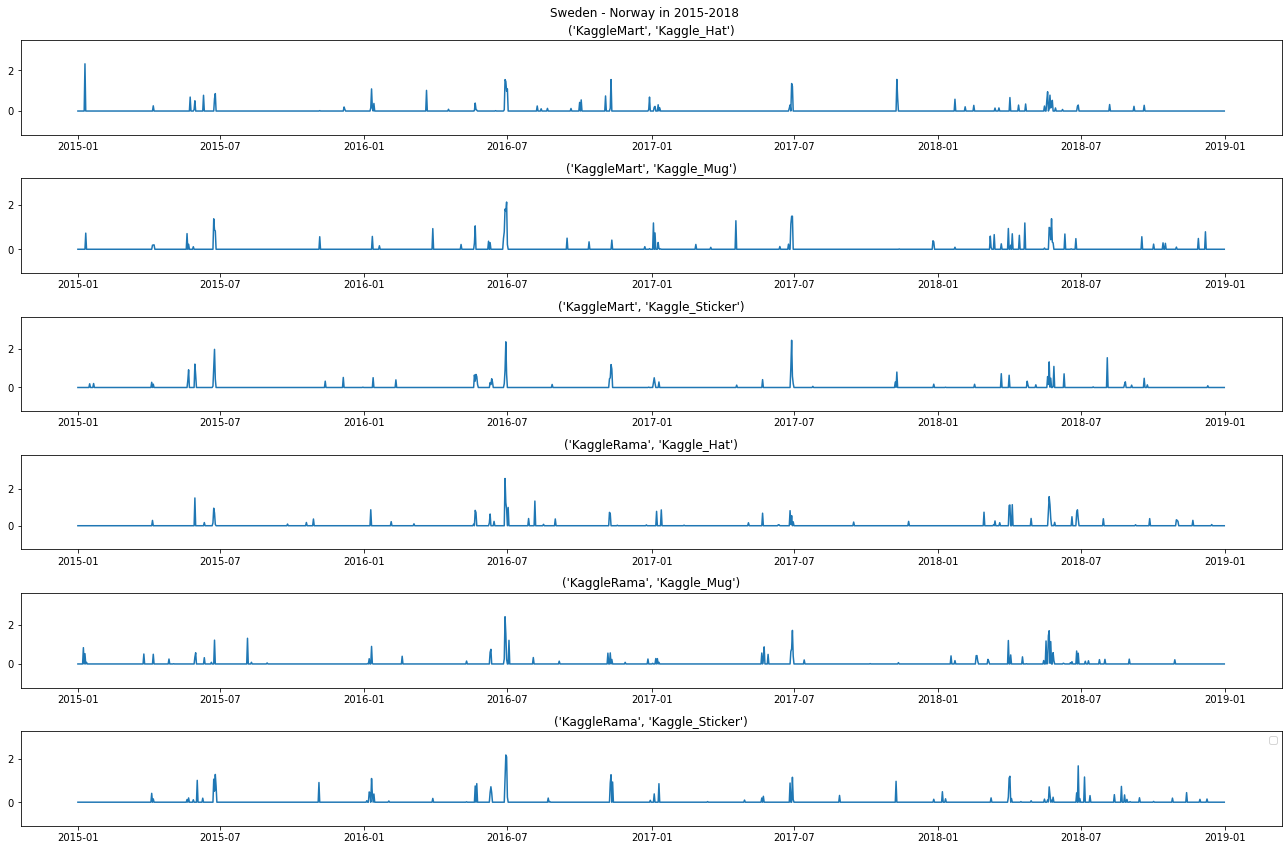

In [21]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 1, i + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    differ = df[df.country == 'Sweden'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 2
    differ[differ < 0] = 0
#     differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), differ)
    ax.set_title(f"{combi}")
plt.suptitle('Sweden - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

Sum them up and we get

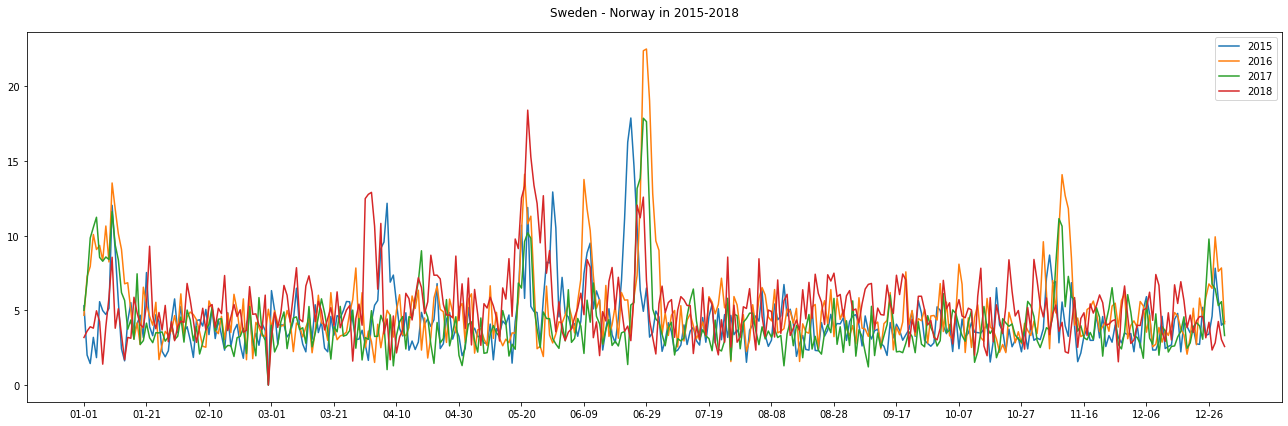

In [22]:
plt.figure(figsize=(18, 6))
res = None
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    differ = df[df.country == 'Sweden'].num_sold - df[df.country == 'Norway'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 0
    differ[differ < 0] = 0
    if res is None:
        res = differ
    else:
        res += differ
res[res < 0] = 0
dates = sorted(res.index.strftime('%m-%d').unique())
for year in range(2015, 2019):
    data = res[res.index.year == year]
    data.index = data.index.strftime('%m-%d')
    plt.plot(dates, data.reindex(dates).fillna(0), label=year)
plt.xticks(dates[::20])
plt.suptitle('Sweden - Norway in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

In conclusion, the difference between Finland and Norway falls on the date of the followings:

1. Around Jan 10.

2. Beginning of April.

3. End of May.

4. End of June.

5. Around August 5.

## Finland Vs Sweden

In [23]:
df1 = train_df.query('country == "Finland" | country == "Sweden"')

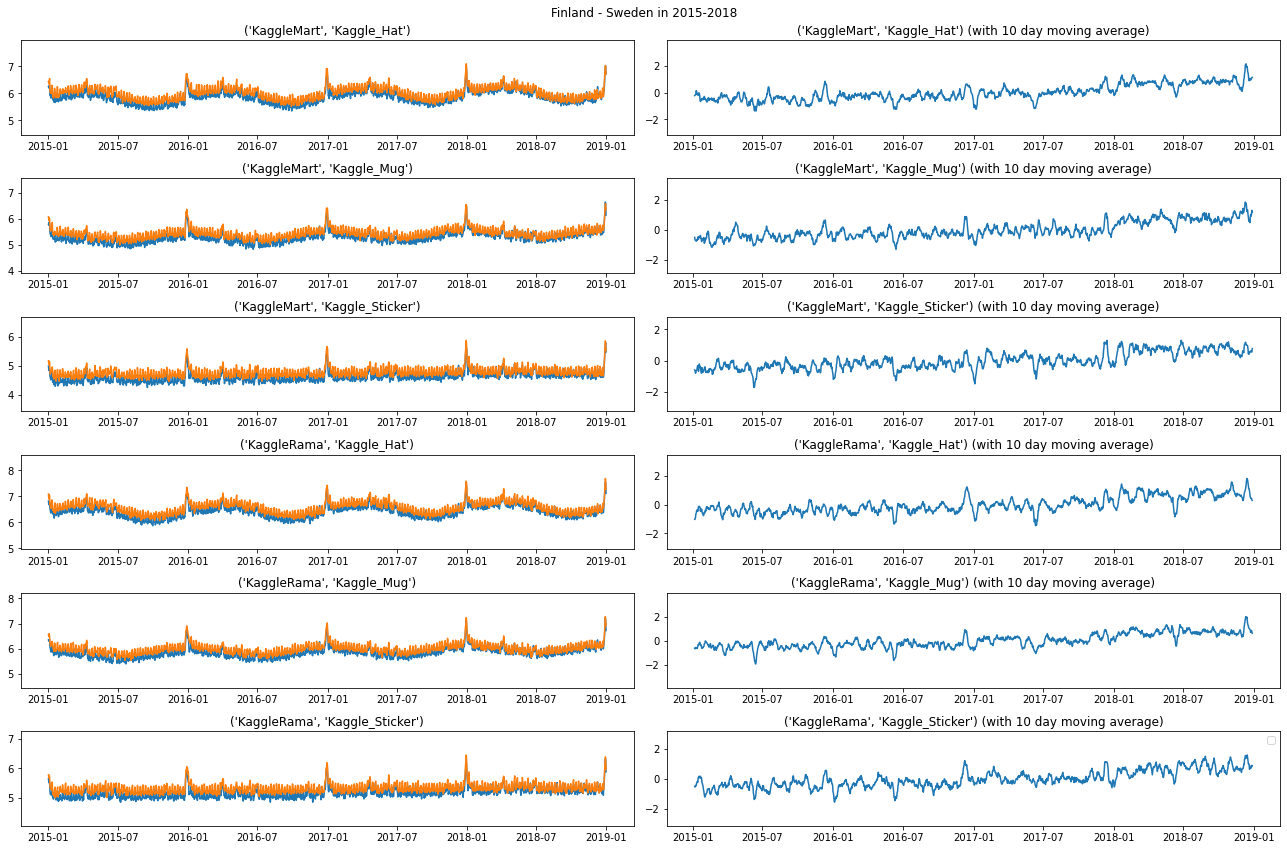

In [24]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 2, i * 2 + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), df[df.country == 'Finland'].num_sold, label='Sweden')
    ax.plot(df.index.unique(), df[df.country == 'Sweden'].num_sold, label='Norway')
    ax.set_title(combi)
    ax2 = plt.subplot(6, 2, i * 2 + 2, ymargin=0.5)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Sweden'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax2.plot(df.index.unique(), differ)
    ax2.set_title(f"{combi} (with 10 day moving average)")
plt.suptitle('Finland - Sweden in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

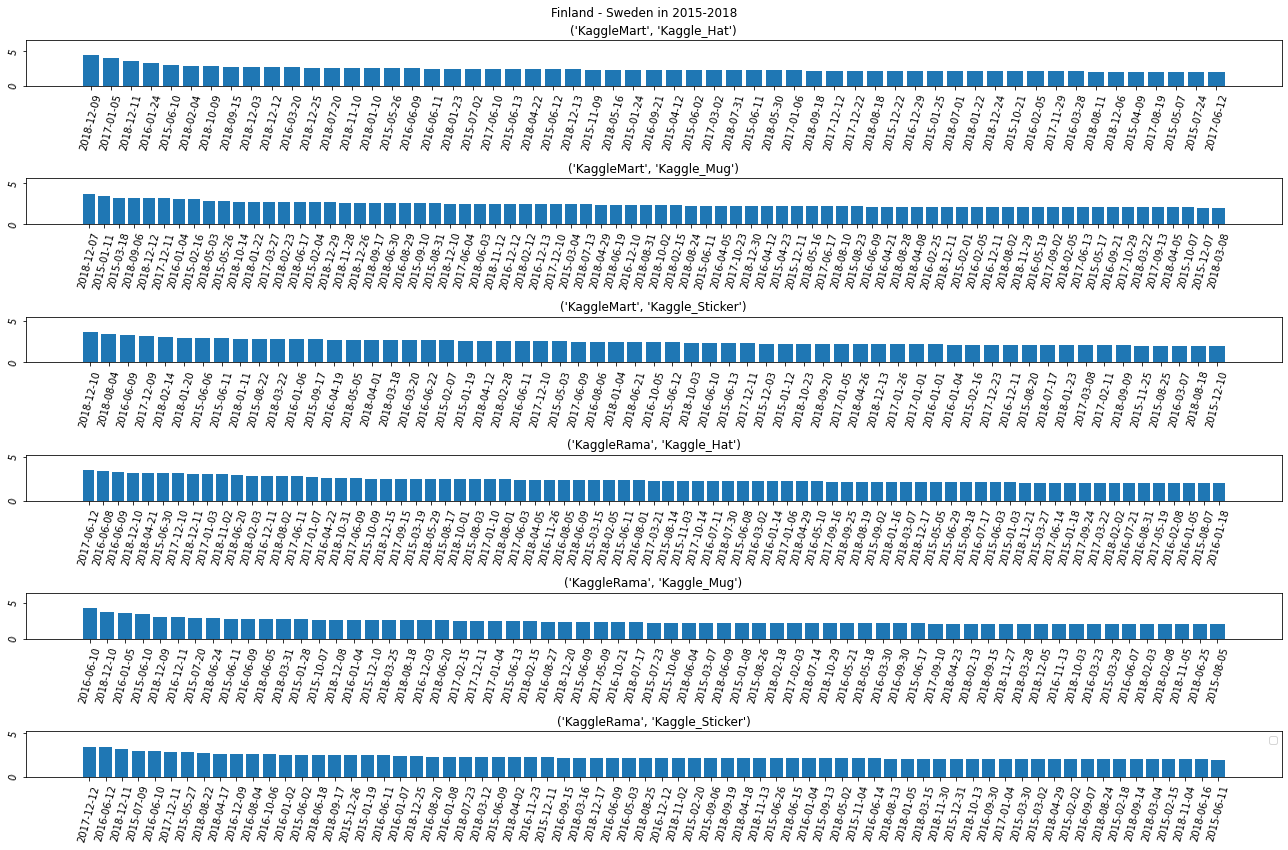

In [25]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax2 = plt.subplot(6, 1, i + 1, ymargin=0.5)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Sweden'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ).sort_values(ascending=False)
    differ = differ[differ > 2]
    ax2.bar(differ.index.astype(str), differ)
    ax2.set_title(f"{combi}")
    ax2.tick_params(rotation=75)
plt.suptitle('Finland - Sweden in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

To see them more clearly, we draw a plot about the outliers

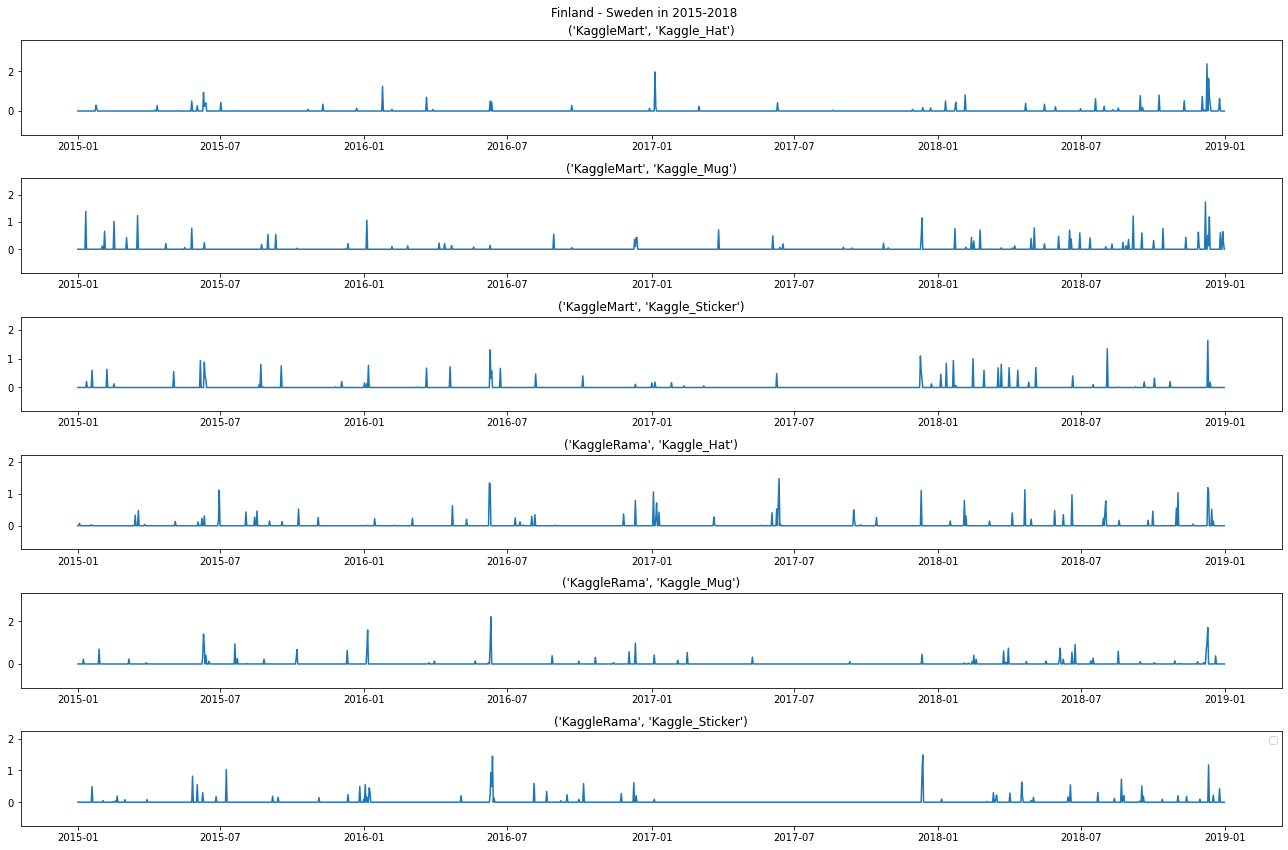

In [26]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(6, 1, i + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Sweden'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 2
    differ[differ < 0] = 0
#     differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), differ)
    ax.set_title(f"{combi}")
plt.suptitle('Finland - Sweden in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

Sum them up and we get

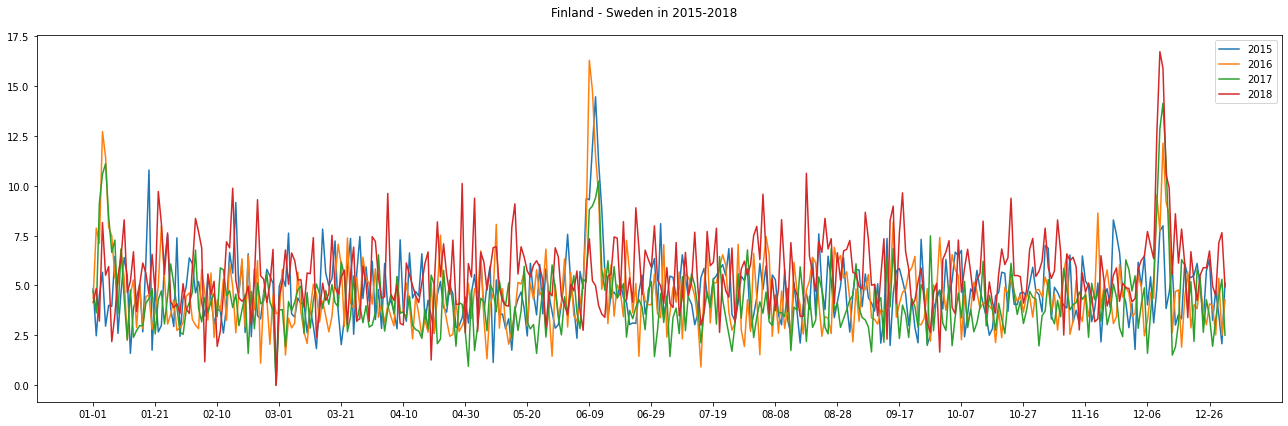

In [27]:
plt.figure(figsize=(18, 6))
res = None
for i, (combi, df) in enumerate(df1.groupby(['store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    differ = df[df.country == 'Finland'].num_sold - df[df.country == 'Sweden'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 0
    differ[differ < 0] = 0
    if res is None:
        res = differ
    else:
        res += differ
res[res < 0] = 0
dates = sorted(res.index.strftime('%m-%d').unique())
for year in range(2015, 2019):
    data = res[res.index.year == year]
    data.index = data.index.strftime('%m-%d')
    plt.plot(dates, data.reindex(dates).fillna(0), label=year)
plt.xticks(dates[::20])
plt.suptitle('Finland - Sweden in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

In conclusion, the difference between Finland and Norway falls on the date of the followings:

1. Around June 10.

2. Around December 10.

3. Beginning of Jan.

## Conclusion

The special dates for different countries are as followed:

Finland: Around June 10; around December 10; beginning of Jan.

Sweden: (None)

Norway: Easter, End of June, Around August 5.

# Difference between stores

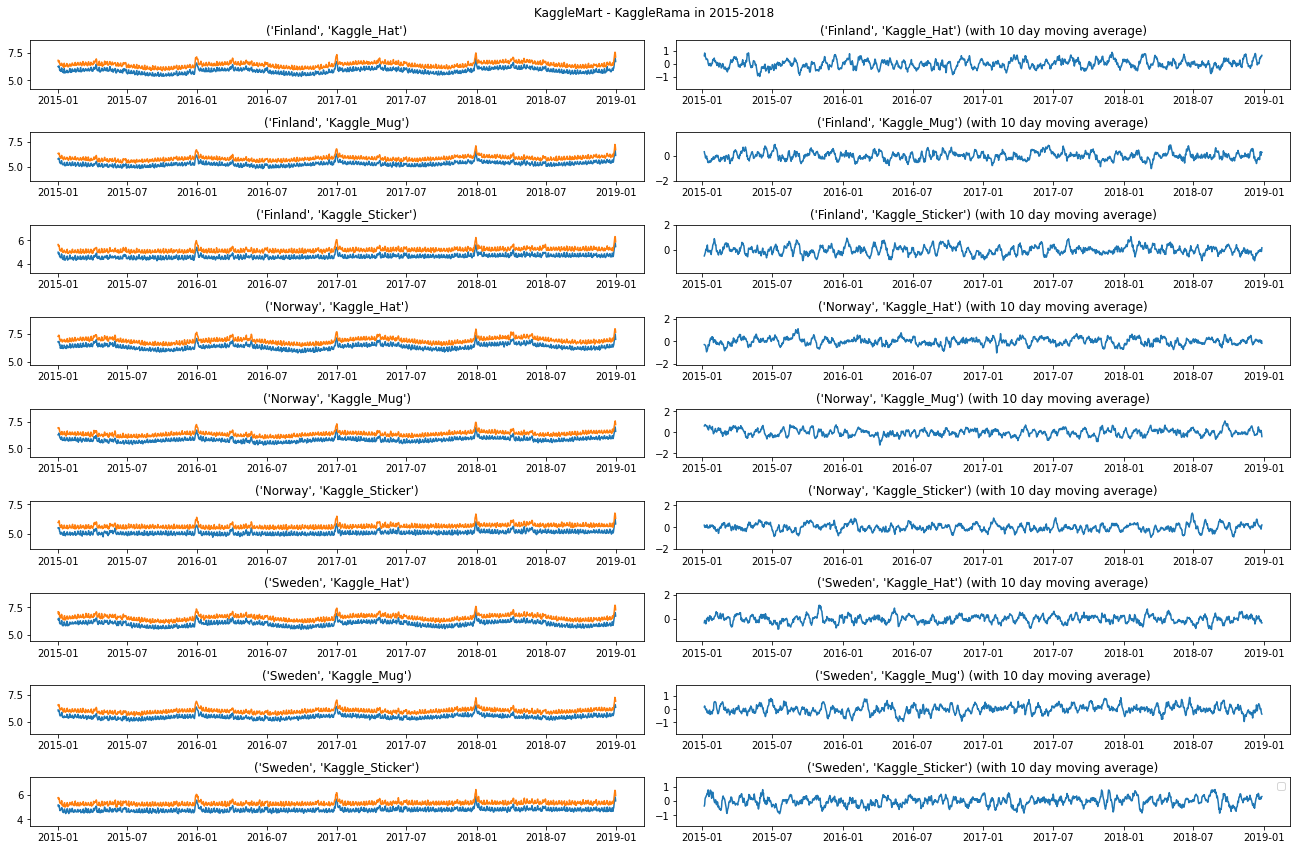

In [28]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(9, 2, i * 2 + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), df[df.store == 'KaggleMart'].num_sold, label='KaggleMart')
    ax.plot(df.index.unique(), df[df.store == 'KaggleRama'].num_sold, label='KaggleRama')
    ax.set_title(combi)
    ax2 = plt.subplot(9, 2, i * 2 + 2, ymargin=0.5)
    differ = df[df.store == 'KaggleMart'].num_sold - df[df.store == 'KaggleRama'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax2.plot(df.index.unique(), differ)
    ax2.set_title(f"{combi} (with 10 day moving average)")
plt.suptitle('KaggleMart - KaggleRama in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

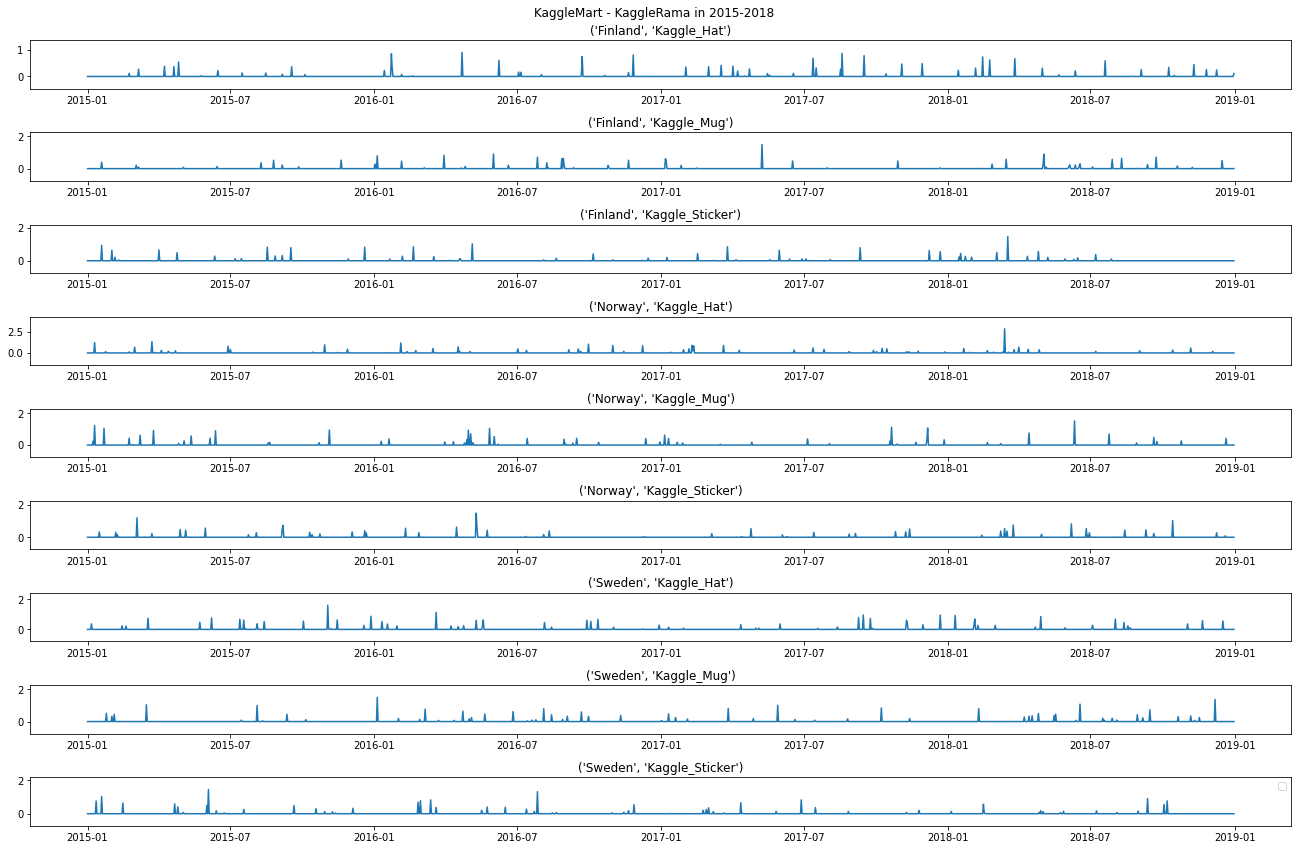

In [29]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'product'])):
    df.num_sold = np.log(df.num_sold)
    ax = plt.subplot(9, 1, i + 1, ymargin=0.5)
#     ax.set_xticks(df.index.unique())
    differ = df[df.store == 'KaggleMart'].num_sold - df[df.store == 'KaggleRama'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 2
    differ[differ < 0] = 0
#     differ = differ.rolling(10, center=True).mean()
#     ax2.set_xticks(df.index.unique())
    ax.plot(df.index.unique(), differ)
    ax.set_title(f"{combi}")
plt.suptitle('KaggleMart - KaggleRama in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()

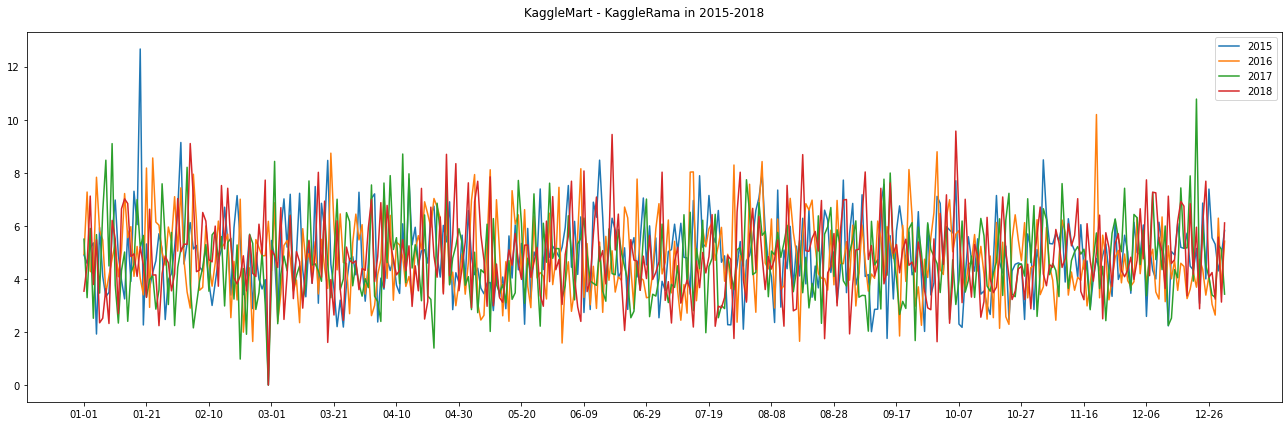

In [30]:
plt.figure(figsize=(18, 6))
res = None
for i, (combi, df) in enumerate(df1.groupby(['country', 'product'])):
    df.num_sold = np.log(df.num_sold)
    differ = df[df.store == 'KaggleMart'].num_sold - df[df.store == 'KaggleRama'].num_sold
    differ = (differ - differ.mean()) / differ.std()
    differ = np.abs(differ)
    differ -= 0
    differ[differ < 0] = 0
    if res is None:
        res = differ
    else:
        res += differ
res[res < 0] = 0
dates = sorted(res.index.strftime('%m-%d').unique())
for year in range(2015, 2019):
    data = res[res.index.year == year]
    data.index = data.index.strftime('%m-%d')
    plt.plot(dates, data.reindex(dates).fillna(0), label=year)
plt.xticks(dates[::20])
plt.suptitle('KaggleMart - KaggleRama in 2015-2018')
plt.legend()
plt.tight_layout()
plt.show()



# Seasonality

In [31]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

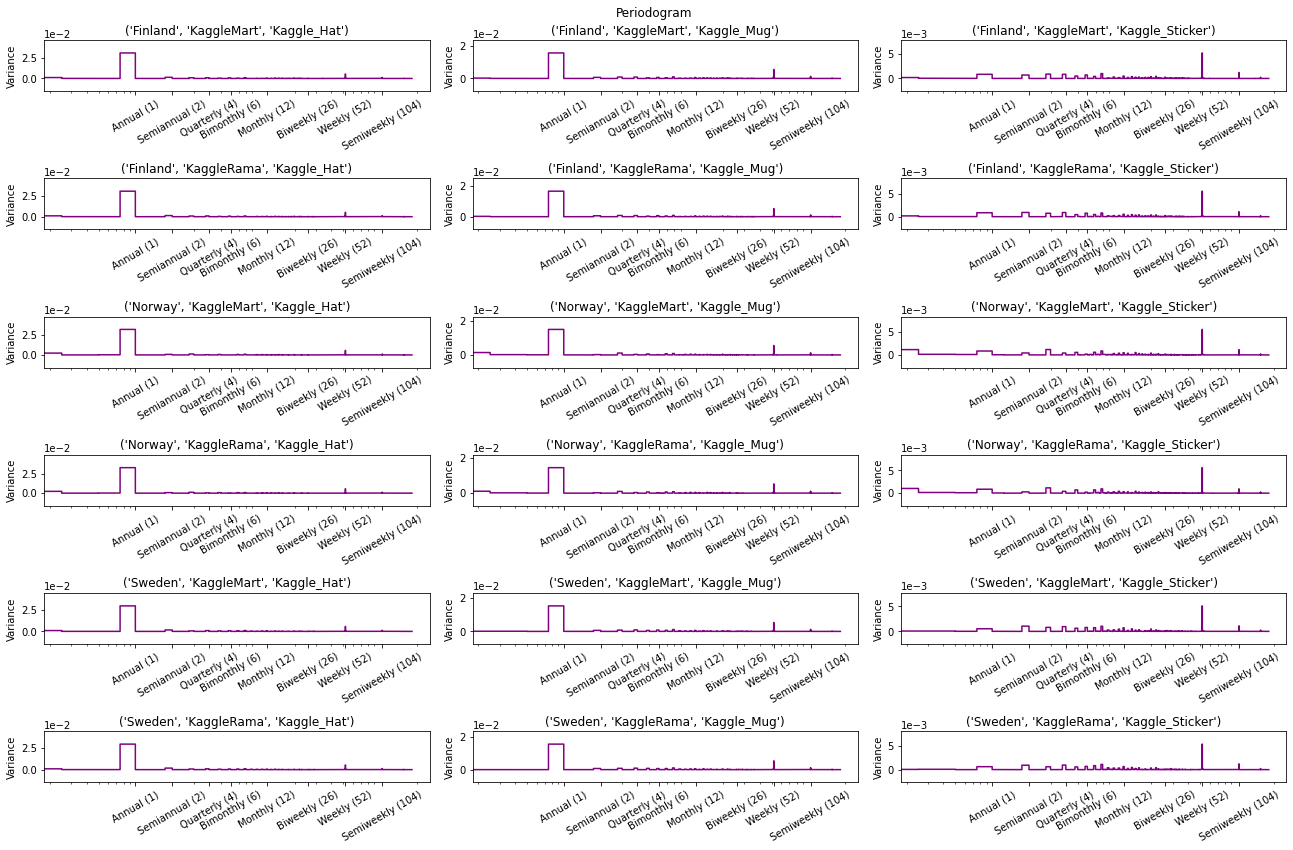

In [32]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax = plot_periodogram(df.num_sold, detrend='linear', ax=ax)
    ax.set_title(f"{combi}")
plt.suptitle('Periodogram')
plt.tight_layout()
plt.show()

We can see the seasonality are much more correlated with products but not countries and stores.

In [33]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index.unique(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()
X['year'] = df.date.dt.year

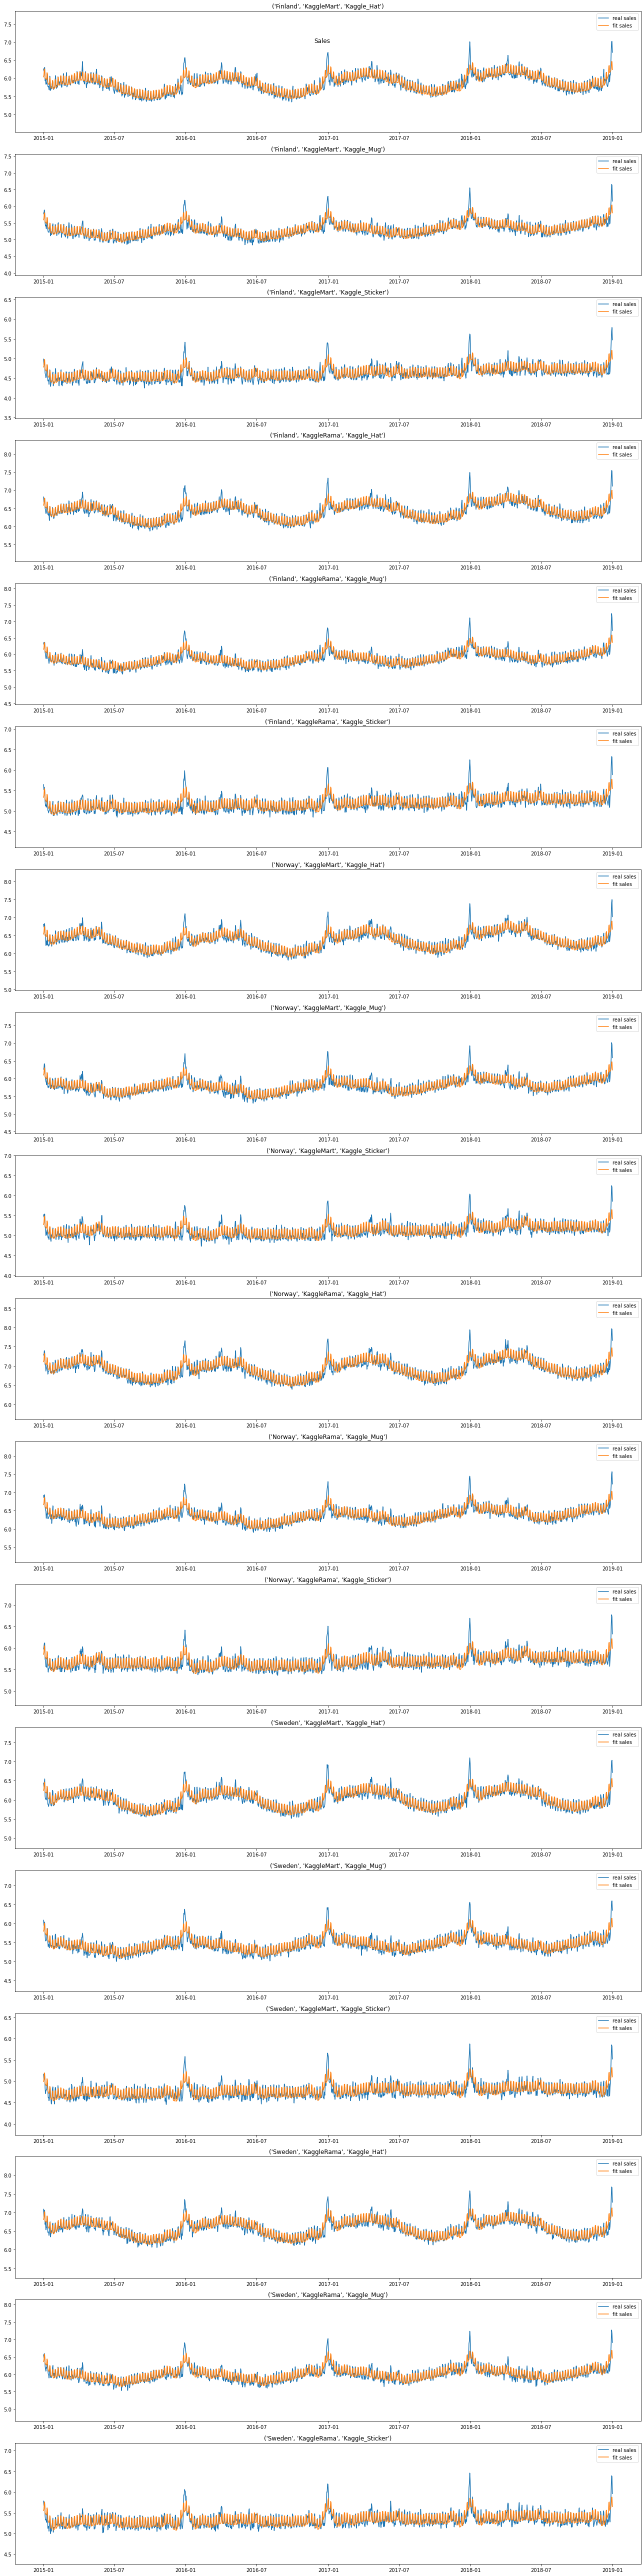

In [34]:
plt.figure(figsize=(18, 12 * 6))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
    X_df = X.merge(gdp, left_on='year', right_index=True)
    X_df.drop(columns=['year'], inplace=True)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_df, df.num_sold)
    ax = plt.subplot(18, 1, i+1, ymargin=0.5)
    ax.plot(df.num_sold, label='real sales')
    ax.plot(df.num_sold.index, model.predict(X_df), label='fit sales')
    ax.set_title(f"{combi}")
    ax.legend()
plt.suptitle('Sales')
plt.tight_layout()
plt.show()

The fit shows that the model captures the seasonality of the data but there are some spikes that the model cannot fit well. Therefore, the next step we should take a look at is these special dates.

# Special Dates

We firstly check on which dates the model is not fitting well. Before finding dates, we should get a threshold for filtering the error, here I use a simple method that is to use boxplot to find the outliers and regard them as representatives.

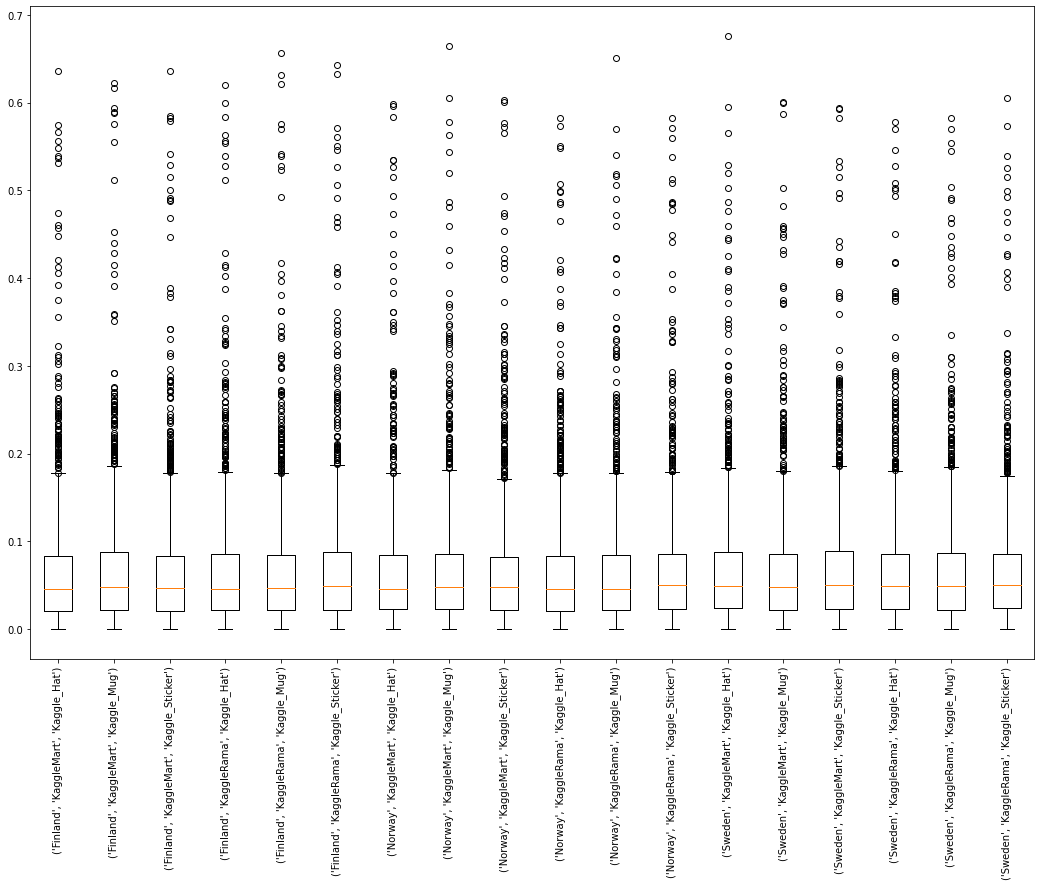

In [35]:
plt.figure(figsize=(18, 12))
boxes = pd.DataFrame()
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
    X_df = X.merge(gdp, left_on='year', right_index=True)
    X_df.drop(columns=['year'], inplace=True)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_df, df.num_sold)
    residual = np.abs(df.num_sold - np.array(model.predict(X_df)))
    residual = residual.to_frame()
    residual = residual.sort_values(by='num_sold', ascending=False)
    boxes[combi] = residual
plt.xticks(rotation='vertical')
plt.boxplot(boxes, labels=boxes.columns)
plt.show()

So you can see most boxplots choose 0.17 as a threshold so we would also like to use that value for further analysis.

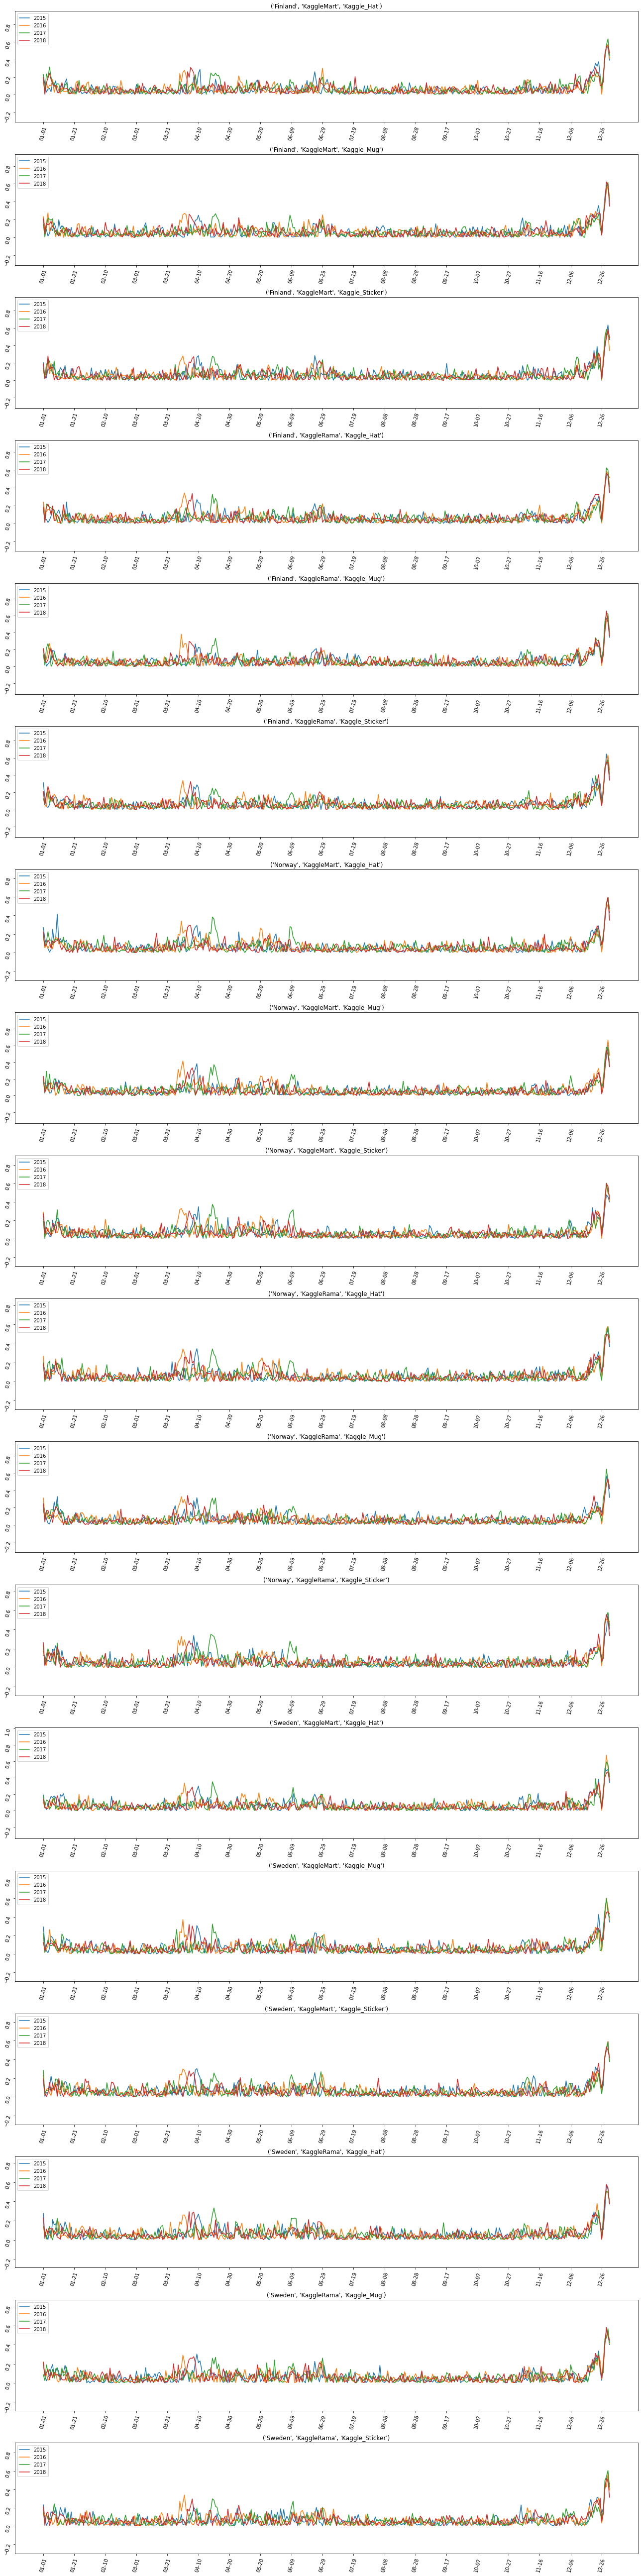

In [36]:
plt.figure(figsize=(18, 12 * 6))
dates = sorted(train_df.date.dt.strftime('%m-%d').unique())
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    df.num_sold = np.log(df.num_sold)
    country = combi[0]
    gdp = np.log(gdp_df.loc[gdp_df.index[:-1], country])
    X_df = X.merge(gdp, left_on='year', right_index=True)
    X_df.drop(columns=['year'], inplace=True)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_df, df.num_sold)
    residual = np.abs(df.num_sold - np.array(model.predict(X_df)))
    ax = plt.subplot(18, 1, i + 1, ymargin=0.5)
    for year in range(2015, 2019):
        data = residual[residual.index.year == year]
        data.index = data.index.strftime('%m-%d')
        ax.plot(dates, data.reindex(dates).fillna(0), label=year)
    ax.set_xticks(dates[::20])
#     print(residual.shape)
    ax.tick_params(rotation=75)
    ax.set_title(f"{combi}")
    ax.legend()
plt.tight_layout()
plt.show()

We can see that the deviations are significant at the beginning of January, Easters and December. In the next section when we build models, we would like to specify the dates we think should be a feature.

# Conclusion

1. GDP plays an important role in predict yearly sales. Partialling out GDP, there is no trend in the sales.

2. There are some special dates in which the sales of one country deviates from other two countries, specifically: 

Finland: Around June 10; around December 10; beginning of Jan.

Sweden: (None)

Norway: Easter, End of June, Around August 5.

3. There is significant seasonality in this time series. 

4. There are some time region where the sales deviates from the seasonality. They are respectively beginning of Jan, Easters, and mid and end of December. 